In [12]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
from google.colab import drive
import tensorflow as tf
with tf.device('/device:GPU:0'):
  drive.mount('/content/drive')
  images_folder = '/content/drive/MyDrive/171/images'
  images_csv = '/content/drive/MyDrive/171/dataset.csv'

Your runtime has 56.9 gigabytes of available RAM

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow

In [13]:
import pandas as pd
import os
import numpy as np
import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers, models

In [16]:
# Load your dataset CSV that contains the labels and image filenames
dataset_csv = pd.read_csv(images_csv)

# Function to load and preprocess images
def load_and_preprocess_image(img_path, index, target_size=(424, 424)):
    # print(f"Processing {img_path}: \t{index}")
    img = image.load_img(img_path, target_size=target_size)
    img = image.img_to_array(img)  # Convert image to numpy array
    # TODO: FIGURE OUT IF SCALING IS NECESSARY
    img = image.img_to_array(img).astype('float32')  # Force float32
    img = img / 255.0  # Normalize image (scaling pixels to [0, 1])
    return img

# Split the data based on the labels
num_samples = 2002
image_height, image_width, channels = 424, 424, 3

# Preallocate arrays
x_train = np.zeros((num_samples, image_height, image_width, channels), dtype=np.float32)
y_train = np.zeros((num_samples,))

with tf.device('/device:GPU:0'):

  num_spiral = 0
  num_elliptical = 0
  num_uncertain = 0

  i = 0
  for _, row in dataset_csv.iterrows():
    objid = row['OBJID']
    image_path = os.path.join(images_folder, f"{objid}.jpg")

    if os.path.exists(image_path):
        # 0 = SPIRAL, 1 = ELLIPTICAL, 2 = UNCERTAIN
        # Number based output for classification

        if row['SPIRAL'] == 1:
            img = load_and_preprocess_image(image_path, i)
            x_train[i] = img
            y_train[i] = 0
            i += 1
        if row['ELLIPTICAL'] == 1:
            img = load_and_preprocess_image(image_path, i)
            x_train[i] = img
            y_train[i] = 1  #
            i += 1
        # if row['UNCERTAIN'] == 1:
            # Attempting training without uncertain
            # img = load_and_preprocess_image(image_path, i)
            # x_train[i] = img
            # y_train[i] = 2  #


In [17]:
print(len(x_train))
print(len(y_train))

2002
2002


In [18]:
from sklearn.model_selection import train_test_split

In [19]:
# First split: train vs temp (temp will be split into val and test)
x_train_final, x_temp, y_train_final, y_temp = train_test_split(
    x_train, y_train, test_size=0.3, random_state=42, stratify=y_train
)

# Second split: validation vs test
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp
)

In [20]:
print(f"Train set: {x_train_final.shape}")
print(f"Validation set: {x_val.shape}")
print(f"Test set: {x_test.shape}")


Train set: (1401, 424, 424, 3)
Validation set: (400, 424, 424, 3)
Test set: (201, 424, 424, 3)


In [24]:
# ImageDataGenerator with 90-degree rotations and horizontal flipping
# Change later, proof of concept
datagen_train = ImageDataGenerator(
    rotation_range=360,  # 0, 90, 180, 270 degrees
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    # brightness_range=[0.8, 1.2]
)

datagen = ImageDataGenerator()

train_generator = datagen_train.flow(x_train_final, y_train_final, batch_size=20)
val_generator = datagen.flow(x_val, y_val, batch_size=20)
test_generator = datagen.flow(x_test, y_test, batch_size=20, shuffle=False)

# Create the generators for each class
print("creating generators")
galaxy_generator = datagen.flow(x_train, y_train, batch_size=20)

IMG_SIZE = (424, 424, 3)
class_names = ['spiral', 'elliptical', 'uncertain']

model = models.Sequential([
    layers.Input(shape=IMG_SIZE),

    # Convolution Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Convolution Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Convolution Block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Convolution Block 3
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Flatten and Dense Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # if y is one-hot encoded
    metrics=['accuracy']
)

creating generators


In [25]:
with tf.device('/device:GPU:0'):
  history = model.fit(
      train_generator,
      validation_data=val_generator,
      epochs=10,
      steps_per_epoch=len(train_generator),
      validation_steps=len(val_generator)
  )
  model.save("vflip_4cnn_20batch.h5")

Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 55s 717ms/step - accuracy: 0.5301 - loss: 0.7910 - val_accuracy: 0.8600 - val_loss: 0.2987
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 50s 708ms/step - accuracy: 0.8398 - loss: 0.3974 - val_accuracy: 0.9050 - val_loss: 0.2709
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 51s 710ms/step - accuracy: 0.8507 - loss: 0.3652 - val_accuracy: 0.8875 - val_loss: 0.3006
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 51s 710ms/step - accuracy: 0.8897 - loss: 0.3027 - val_accuracy: 0.9275 - val_loss: 0.1902
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 51s 711ms/step - accuracy: 0.9191 - loss: 0.2220 - val_accuracy: 0.8650 - val_loss: 0.2916
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 50s 707ms/step - accuracy: 0.9188 - loss: 0.2090 - val_accuracy: 0.9325 - val_loss: 0.1458
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 50s 710ms/step - accuracy: 0.9494 - loss: 0.1526 - val_accuracy: 0.9475 - val_loss: 0.1256
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 50s 708ms/step - accuracy: 0.9374 - loss: 0.1369 - val_accu

Training seemed to have stalled at ~66% accuracy
Could be a few things:
  - Need a deeper / more complex model
  - Need to augment the data more correctly

  - My running theory
    - "Uncertain" data entries are 1/3 of the dataset
      - It is not able to determine which ones are uncertain because they look too much like Elliptical or Spiral

      - Would mean a 1/3 reduction in accuracy?

Next Attempts:
   - Add more convolutional layers
   - Change batch size
   - Remove uncertains????
   - Change augmentation
   - Increase # epochs

In [26]:
import matplotlib.pyplot as plt

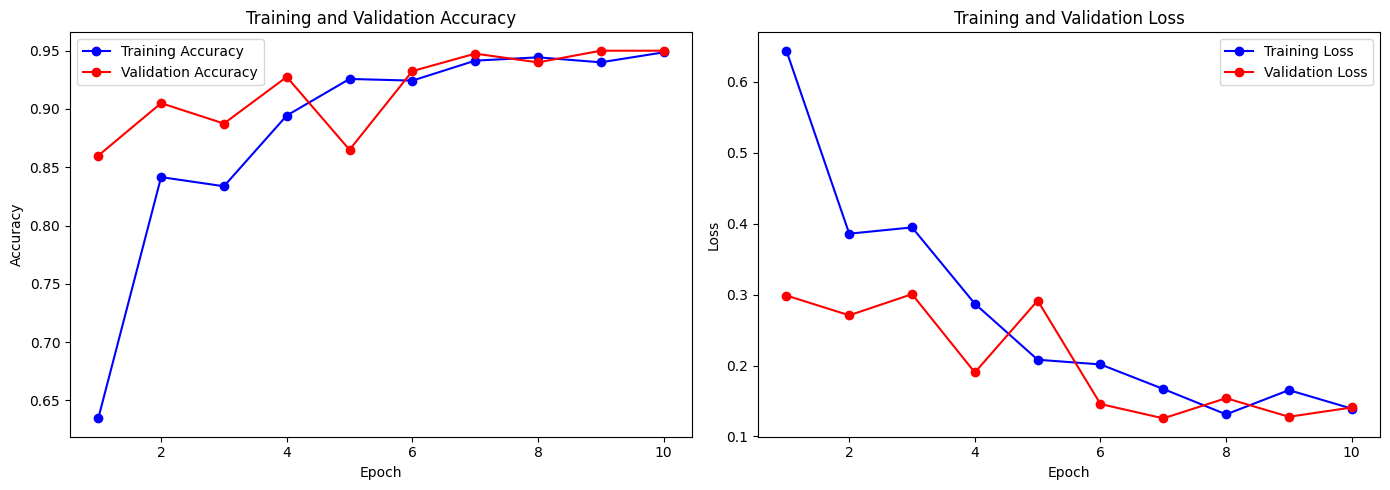

In [27]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call it after training
plot_training_history(history)

In [30]:
from tensorflow.keras.models import load_model

# model = load_model('/content/drive/MyDrive/171/vflip_4cnn_unc_del.h5')

# Predict probabilities
pred_probs = model.predict(test_generator, steps=len(test_generator))

# Get the predicted class indices
predicted_classes = np.argmax(pred_probs, axis=1)

# Total correct
total_correct = 0

total_no_uncertain = 0
total_correct_no_uncertain = 0

# Now you can print actual vs predicted for some samples
for i in range(len(y_test)):
    true_label = class_names[int(y_test[i])]
    predicted_label = class_names[predicted_classes[i]]
    confidence = np.max(pred_probs[i])  # Get confidence score
    if confidence > 0.5:
      print(f"Sample {i}: True: {true_label}, Predicted: {predicted_label} (Confidence: {confidence:.2f})")
    else:
      print(f"Sample {i}: True: {true_label}, Predicted: uncertain (Confidence: {confidence:.2f})")
      predicted_label = "uncertain"
    if true_label == predicted_label:
        total_correct += 1

# Calculate accuracy
accuracy = total_correct / len(y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
Sample 0: True: elliptical, Predicted: elliptical (Confidence: 0.98)
Sample 1: True: spiral, Predicted: spiral (Confidence: 0.99)
Sample 2: True: spiral, Predicted: spiral (Confidence: 0.84)
Sample 3: True: spiral, Predicted: spiral (Confidence: 0.87)
Sample 4: True: spiral, Predicted: spiral (Confidence: 1.00)
Sample 5: True: spiral, Predicted: elliptical (Confidence: 0.74)
Sample 6: True: spiral, Predicted: spiral (Confidence: 0.93)
Sample 7: True: elliptical, Predicted: elliptical (Confidence: 1.00)
Sample 8: True: elliptical, Predicted: elliptical (Confidence: 1.00)
Sample 9: True: elliptical, Predicted: elliptical (Confidence: 0.96)
Sample 10: True: spiral, Predicted: spiral (Confidence: 0.85)
Sample 11: True: elliptical, Predicted: elliptical (Confidence: 0.98)
Sample 12: True: elliptical, Predicted: elliptical (Confidence: 1.00)
Sample 13: True: spiral, Predicted: spiral (Confidence: 0.98)
Sample 14: True: spiral, Predicted: spiral (Confid